# **Machine Learning: Project Part 2**

---

**Author: Damien Farrell**

---

## **Project Part 2: Seal Call Discrimination**

### **Objective**
The aim of this project is to analyze a recorded dataset to investigate the feasibility of discriminating between different seal calls. The project is structured in steps to build a machine learning model that can potentially detect seal calls from audio recordings. While creating a fully functional detector is the ultimate goal, it may not be the final outcome of this project.

#### **Step A: Data Pre-processing**

This step is completed in notebook `data_preprocessing.ipynb`. The file `processed_data.pkl` was produced from this notebook.

#### **Step B: Model Training**
1. **Dataset Utilisation**:
   - Use the prepared spectrogram dataset to train the machine learning model.

3. **Evaluation**:
   - Test the model’s performance on a separate test dataset.

#### **Step C: Refine**
1. **Parameter Tuning**:
   - Adjust parameters in the data extraction/spectrogram creation process (e.g., `nfft`, `noverlap`).
   - Manage computational costs by splitting `.wav` files using tools like `pydub`.

2. **Validation**:
   - Apply the Rupe B/No Call classifier on an entire `.wav` file (held back during training).
   - Ensure no false positives due to the presence of other annotated calls.

In [465]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow.keras.regularizers import l2



---

### **Step B: Model Training** 

---

In [466]:
# Load in processed data
df = pd.read_pickle('processed_data.pkl')
df.head()

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,file_name,folder_name,snippet_spectrogram,snippet_times,snippet_frequencies
0,1,Spectrogram 1,1,4.136987,4.657535,173.956,286.792,0.5205,112.836,-82.85,G Rupe,5711.211013040024,Guttural rupe,"[[10.569122314453125, 4.712647438049316, 1.273...","[4.131708333333333, 4.1445, 4.157291666666667,...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
1,2,Spectrogram 1,1,3.789955,4.264841,371.419,451.345,0.4749,79.926,-92.16,G Rupe,5711.211013040024,Guttural rupe,"[[42.39829635620117, 55.68126678466797, 83.361...","[3.7863333333333333, 3.799125, 3.8119166666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
2,3,Spectrogram 1,1,14.840188,15.406398,136.660,445.248,0.5662,308.588,-88.96,G Rupe,5711.211013040024,Guttural rupe,"[[29.341825485229492, 8.032623291015625, 43.69...","[14.838333333333333, 14.851125, 14.86391666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
3,4,Spectrogram 1,1,24.543802,25.082615,167.519,392.347,0.5388,224.828,-86.10,G Rupe,5711.211013040024,Guttural rupe,"[[0.28541040420532227, 0.41072168946266174, 2....","[24.547208333333334, 24.56, 24.572791666666667...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
4,5,Spectrogram 1,1,35.989220,36.573694,119.027,436.431,0.5845,317.405,-80.18,G Rupe,5711.211013040024,Guttural rupe,"[[13.951732635498047, 23.50061798095703, 20.28...","[35.982958333333336, 35.99575, 36.008541666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."


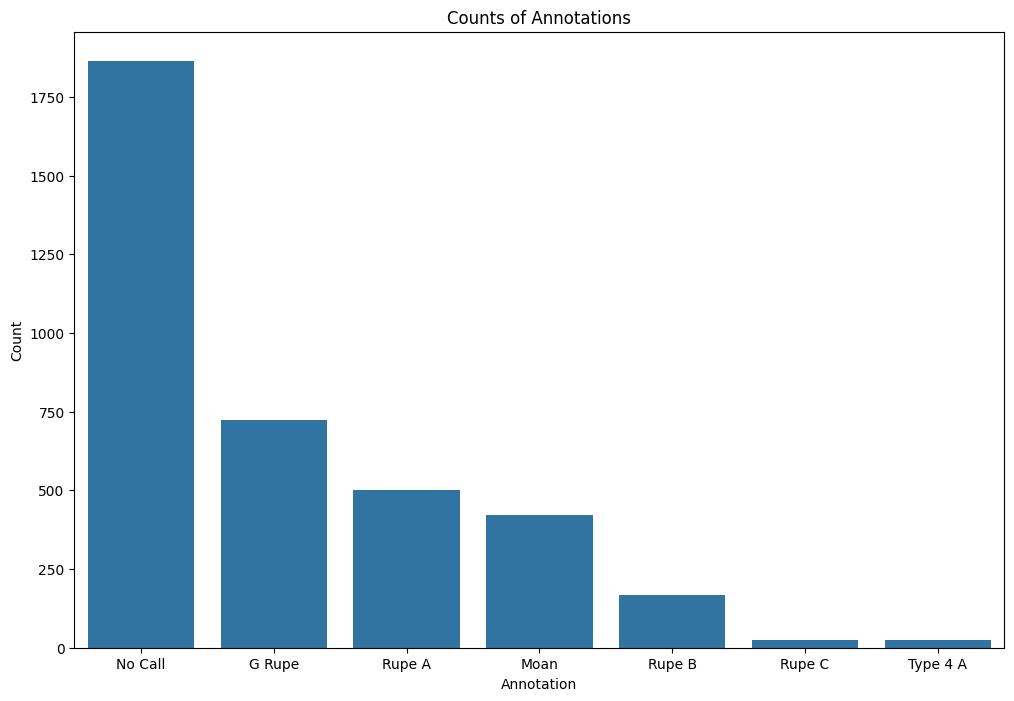

In [467]:
# Count the values
annotation_counts = df['Annotation'].value_counts()

# Create the barplot
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=annotation_counts.index, y=annotation_counts.values, ax=ax)

ax.set_xlabel("Annotation")
ax.set_ylabel("Count")
ax.set_title("Counts of Annotations")
plt.show()

In [468]:
# Perform one-hot encoding
df = pd.get_dummies(df, columns=['Annotation'], prefix='Annotation')

In [469]:
# Get the shapes
shapes = df['snippet_spectrogram'].apply(lambda x: x.shape if isinstance(x, np.ndarray) else None)

# Count unique shapes
print("Unique shapes in 'snippet_spectrogram':")
print(shapes.value_counts())

Unique shapes in 'snippet_spectrogram':
snippet_spectrogram
(42, 84)    3728
Name: count, dtype: int64


In [470]:
X = df[['snippet_spectrogram']].to_numpy()

# "Flatten" the (3742, 1) array to (3742,)
X = X.ravel()
print(X.shape)

# Stack along a new axis to get shape (3742, 42, 84)
X = np.stack(X, axis=0)
print(X.shape)


(3728,)
(3728, 42, 84)


In [471]:
# Reshape to 2D for MinMaxScaler
X_reshaped = X.reshape(-1, X.shape[-2])  # Shape: (3742 * 42, 84)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back to the original shape
X = X_scaled.reshape(X.shape)

X.shape

(3728, 42, 84)

In [472]:
X = np.stack(df['snippet_spectrogram'].values)
y = df[[col for col in df.columns if col.startswith("Annotation_")]]  # Select annotation columns

# `y` contains one-hot encoded labels
stratify_labels = y.idxmax(axis=1)

# First split: Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=stratify_labels,
    shuffle=True
)

# Second split: Train/Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42,
    stratify=y_train.idxmax(axis=1),
    shuffle=True
)

# Output shapes
train_shape = X_train.shape
val_shape = X_val.shape
test_shape = X_test.shape

train_shape, val_shape, test_shape

((2236, 42, 84), (746, 42, 84), (746, 42, 84))

In [473]:
stratify_labels

0        Annotation_G Rupe
1        Annotation_G Rupe
2        Annotation_G Rupe
3        Annotation_G Rupe
4        Annotation_G Rupe
               ...        
3723    Annotation_No Call
3724    Annotation_No Call
3725    Annotation_No Call
3726    Annotation_No Call
3727    Annotation_No Call
Length: 3728, dtype: object

#### **Model 1**

In [474]:
def plot_loss(history, which='loss'):
    plt.plot(history.history[which], label='train')
    try:
        plt.plot(history.history['val_'+which], label='validation')
    except:
        None
    plt.xlabel('Epoch')
    plt.ylabel(which)
    plt.legend()
    plt.grid(True)

In [475]:
input_shape = (42, 84, 1)
num_classes = len(stratify_labels.unique())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [476]:
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 42, 84, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 21, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 21, 42, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 10, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 10, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 5, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,927 (1.66 MB)

 Trainable params: 433,927 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [477]:
# Define focal loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred)
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

In [478]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss= focal_loss(gamma=2., alpha=0.25),  #from_logits=False as softmax is on the output of the CNN
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(thresholds=0.5, name="precision"),
        tf.keras.metrics.Recall(thresholds=0.5, name="recall"),
        tf.keras.metrics.AUC(multi_label=True, name="auc"),
        tf.keras.metrics.F1Score(threshold=0.5, average='macro', name="f1_score"),
    ]
)

In [479]:
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [480]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5985 - auc: 0.6469 - f1_score: 0.1642 - loss: 0.0365 - precision: 0.7253 - recall: 0.2741 - val_accuracy: 0.6830 - val_auc: 0.8478 - val_f1_score: 0.1900 - val_loss: 0.0245 - val_precision: 0.8291 - val_recall: 0.2924
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6891 - auc: 0.8111 - f1_score: 0.2530 - loss: 0.0207 - precision: 0.8732 - recall: 0.5375 - val_accuracy: 0.7277 - val_auc: 0.8630 - val_f1_score: 0.2492 - val_loss: 0.0222 - val_precision: 0.8563 - val_recall: 0.6384
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7809 - auc: 0.8716 - f1_score: 0.2993 - loss: 0.0148 - precision: 0.9197 - recall: 0.6119 - val_accuracy: 0.8482 - val_auc: 0.9019 - val_f1_score: 0.4719 - val_loss: 0.0131 - val_precision: 0.9235 - val_recall: 0.7812
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8264 - auc: 0.9031 - f1_score: 0.4443 - loss: 0.0147 - precision: 0.9069 - recall: 0.7392

In [481]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8873 - auc: 0.8986 - f1_score: 0.5670 - loss: 0.0152 - precision: 0.8991 - recall: 0.8625


{'accuracy': 0.8914209008216858,
 'auc': 0.944395899772644,
 'f1_score': 0.5827944874763489,
 'loss': 0.014302974566817284,
 'precision': 0.9030470848083496,
 'recall': 0.8739946484565735}

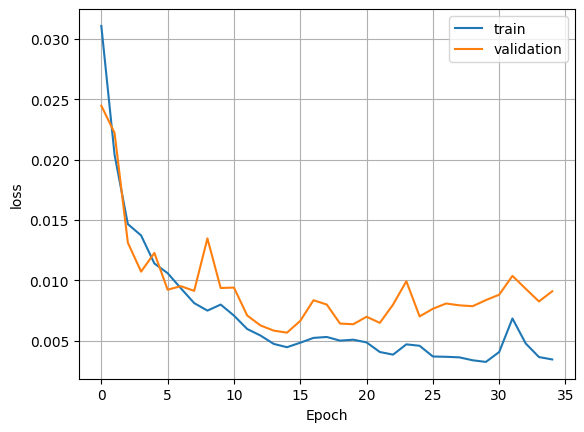

In [482]:
plot_loss(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


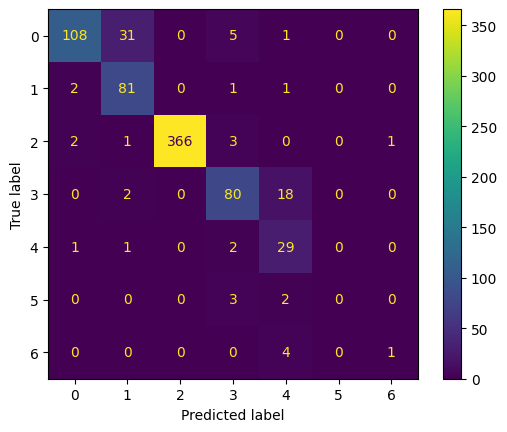

In [483]:
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert to class labels

# Convert y_test from one-hot to class labels
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(y_test.shape[1]))
disp.plot(cmap='viridis');

#### **Model 2**

In [484]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # from_logits=False as softmax is on the output of the CNN
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(thresholds=0.5, name="precision"),
        tf.keras.metrics.Recall(thresholds=0.5, name="recall"),
        tf.keras.metrics.AUC(multi_label=True, name="auc"),  # Add AUC for multi-class classification
        tf.keras.metrics.F1Score(threshold=0.5, average='macro', name="f1_score"),
    ]
)

In [485]:
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [486]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9468 - auc: 0.9703 - f1_score: 0.7596 - loss: 128.2454 - precision: 0.9564 - recall: 0.9433 - val_accuracy: 0.8973 - val_auc: 0.9373 - val_f1_score: 0.5817 - val_loss: 0.4646 - val_precision: 0.9103 - val_recall: 0.8839
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9573 - auc: 0.9587 - f1_score: 0.7138 - loss: 1.1159 - precision: 0.9654 - recall: 0.9445 - val_accuracy: 0.9085 - val_auc: 0.9455 - val_f1_score: 0.6248 - val_loss: 0.3324 - val_precision: 0.9172 - val_recall: 0.8906
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9635 - auc: 0.9601 - f1_score: 0.6803 - loss: 0.1138 - precision: 0.9703 - recall: 0.9487 - val_accuracy: 0.9018 - val_auc: 0.9435 - val_f1_score: 0.6336 - val_loss: 0.2997 - val_precision: 0.9174 - val_recall: 0.8929
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9624 - auc: 0.9163 - f1_score: 0.6774 - loss: 0.1195 - precision: 0.9687 - recall: 0.95

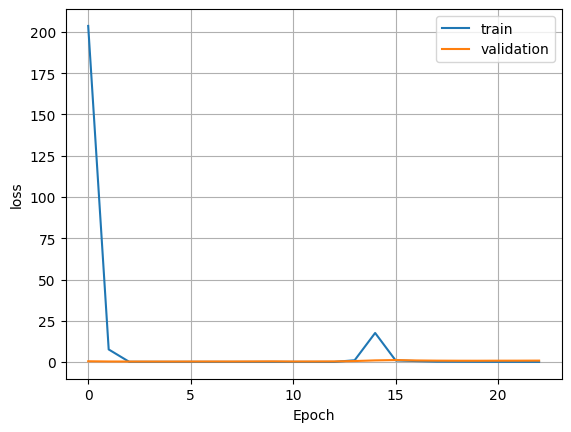

In [487]:
plot_loss(history)

In [488]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9227 - auc: 0.8608 - f1_score: 0.6125 - loss: 200.8577 - precision: 0.9283 - recall: 0.9204


{'accuracy': 0.9276139140129089,
 'auc': 0.9299928545951843,
 'f1_score': 0.6248780488967896,
 'loss': 340.36505126953125,
 'precision': 0.9336941838264465,
 'recall': 0.9249329566955566}

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


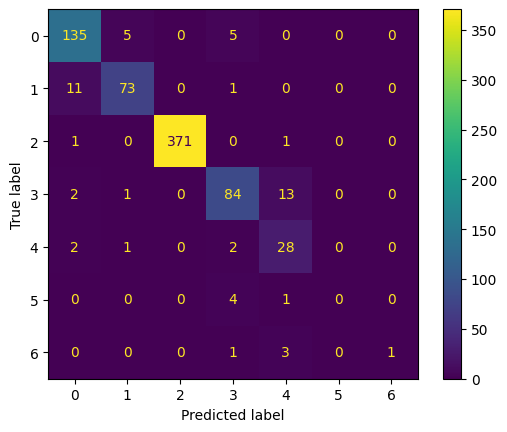

In [489]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert y_test from one-hot to class labels
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(y_test.shape[1]))
disp.plot(cmap='viridis');

#### **Model 3: EfficientNet**

In [490]:
# Training data generator
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

# Validation data generator
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Test data generator
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [491]:
# Add a channel dimension
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [492]:
train_iterator = train_datagen.flow(X_train, y_train, batch_size=30, shuffle=True)
val_iterator = val_datagen.flow(X_val, y_val, batch_size=len(y_val), shuffle=True)
test_iterator = test_datagen.flow(X_test, y_test, batch_size=len(y_test), shuffle=True)

In [493]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

# Load the EfficientNetB4 base model
weights_path = 'noisy_student_efficientnet_b4.h5'

base_model = EfficientNetB4(
    weights=weights_path,
    include_top=False,
    pooling='avg',
)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new custom top layers
model = keras.models.Sequential([
    base_model,                          # Add the base model
    layers.Dropout(0.2),                 # Add Dropout
    layers.Dense(7, activation='softmax', kernel_regularizer=l2(0.01))  # Add custom Dense layer for classification
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Display the model architecture
model.summary()


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 7)              │        12,551 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,686,374 (67.47 MB)

 Trainable params: 12,551 (49.03 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [494]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=20,
    restore_best_weights=True
)

callback_modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_EN.keras', monitor='val_loss', save_best_only=True)

In [495]:
history = model.fit(
    train_iterator,
    batch_size=32,
    epochs=50,
    validation_data=val_iterator,
    callbacks=[early_stop, callback_modelcheckpoint]
)

Epoch 1/50


c:\Users\Damien\ATU\machine-learning-project-2\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.3396 - loss: 2.6063 - val_accuracy: 0.4973 - val_loss: 1.6064
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.4188 - loss: 2.0438 - val_accuracy: 0.5107 - val_loss: 1.5040
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.4441 - loss: 2.2709 - val_accuracy: 0.5067 - val_loss: 1.4889
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.4298 - loss: 1.7031 - val_accuracy: 0.5040 - val_loss: 1.4546
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.4585 - loss: 1.6680 - val_accuracy: 0.5777 - val_loss: 1.5059
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.4505 - loss: 1.6181 - val_accuracy: 0.5442 - val_loss: 1.4239
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.4871 - loss: 1.6784 - val_accuracy: 0.5349 - val_loss: 1.4208
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.4912 - loss: 1.5603 - val_accuracy: 0.5295 - val_loss: 

In [496]:
saved_model = load_model('best_model_EN.keras')

In [497]:
loss, accuracy = saved_model.evaluate(test_iterator)
print("Test Accuracy: ", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5684 - loss: 1.3229
Test Accuracy:  0.5683646202087402


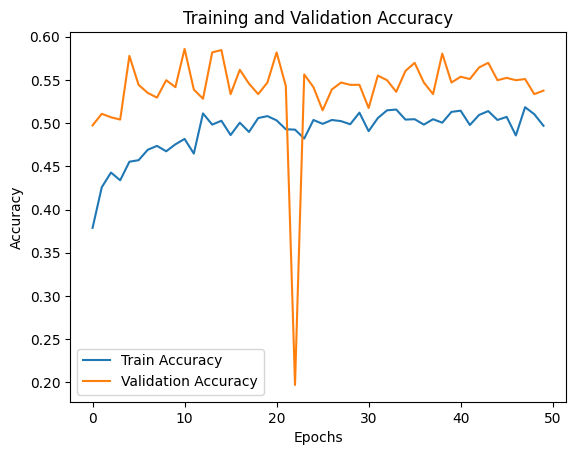

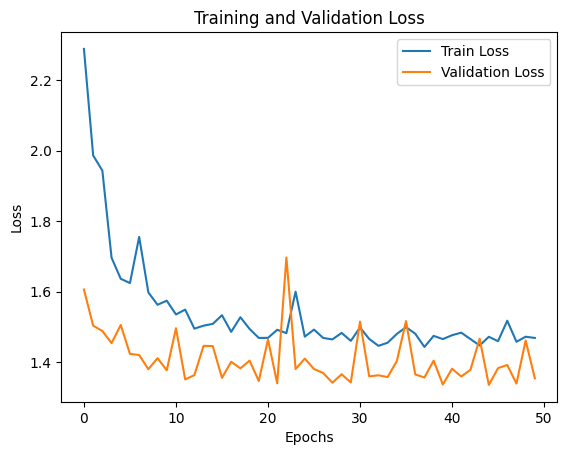

In [498]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step


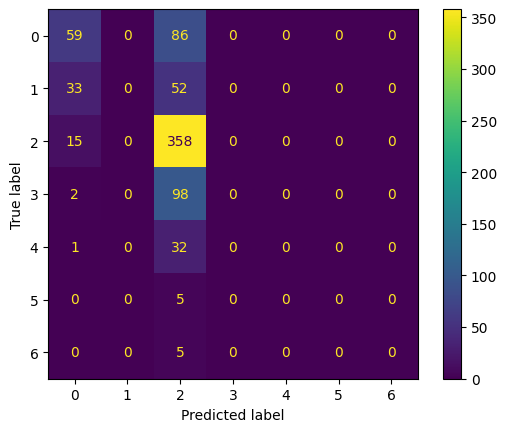

In [499]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert y_test from one-hot to class labels
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(y_test.shape[1]))
disp.plot(cmap='viridis');

---

### **Step C: Refine**

---

---

### **References**

1. [Bird Song Dataset on Kaggle](https://www.kaggle.com/code/sophiagnetneva/cnn-for-sound-classification-bird-calls-90)





---

# END